In [1]:
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread
from skimage.io import imsave
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = '/home/biorobotica/docker_volumen/datasets/tableware/'
train_image_dir = os.path.join(data_dir, 'train')
val_image_dir = os.path.join(data_dir, 'val')
import gc; gc.enable() # memory is tight
from skimage.morphology import label

In [2]:
BATCH_SIZE = 20
EDGE_CROP = 2
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
#IMG_SCALING = (1, 1)
IMG_SCALING = None
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'annotations')
    images = glob.glob(os.path.join(img_path,'*.*'))
    return [image.split('/')[-1] for image in images]

In [4]:
# print(get_all_imgs())
TRAIN_IMGS, TEST_IMGS = train_test_split(get_all_imgs())
#print(len(TRAIN_IMGS))
#print(len(TEST_IMGS))

In [5]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final

In [6]:
def make_image_gen(img_file_list=TRAIN_IMGS, batch_size = BATCH_SIZE):
    all_batches = TRAIN_IMGS
    out_rgb = []
    out_mask = []
    out_classes = []
    img_path = os.path.join(train_image_dir,'images')
    mask_path = os.path.join(train_image_dir,'annotations')
    while True:
        np.random.shuffle(all_batches)
        for c_img_id in all_batches:
            c_img_name_split = c_img_id.split('_')
            c_img_class = c_img_id.split('-')[1]
            c_img_name = c_img_id.split('-')[0] + "."  + c_img_id.split('-')[2].split('.')[1]
            c_img = imread(os.path.join(img_path,c_img_name))
            c_img = cv2_brightness_augment(c_img)
            c_mask = imread(os.path.join(mask_path,c_img_id))
            if IMG_SCALING is not None:
                c_img = cv2.resize(c_img,(256,256),interpolation = cv2.INTER_AREA)
                c_mask = cv2.resize(c_mask,(256,256),interpolation = cv2.INTER_AREA)
            c_mask = np.reshape(c_mask,(c_mask.shape[0],c_mask.shape[1],-1))
            c_mask = c_mask > 0
            out_rgb += [c_img]
            out_mask += [c_mask]
            out_classes += [c_img_class]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0), out_classes
                out_rgb, out_mask, out_classes=[], [], []

In [7]:
train_gen = make_image_gen()
train_x, train_y, img_class = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())
print(img_class)

('x', (20, 480, 640, 3), 0.0, 1.0)
('y', (20, 480, 640, 1), False, True)
['knife', 'bowl', 'bowl', 'bowl', 'bowl', 'spoon', 'glass', 'glass', 'glass', 'dish', 'spoon', 'glass', 'dish', 'dish', 'bowl', 'spoon', 'dish', 'spoon', 'bowl', 'dish']


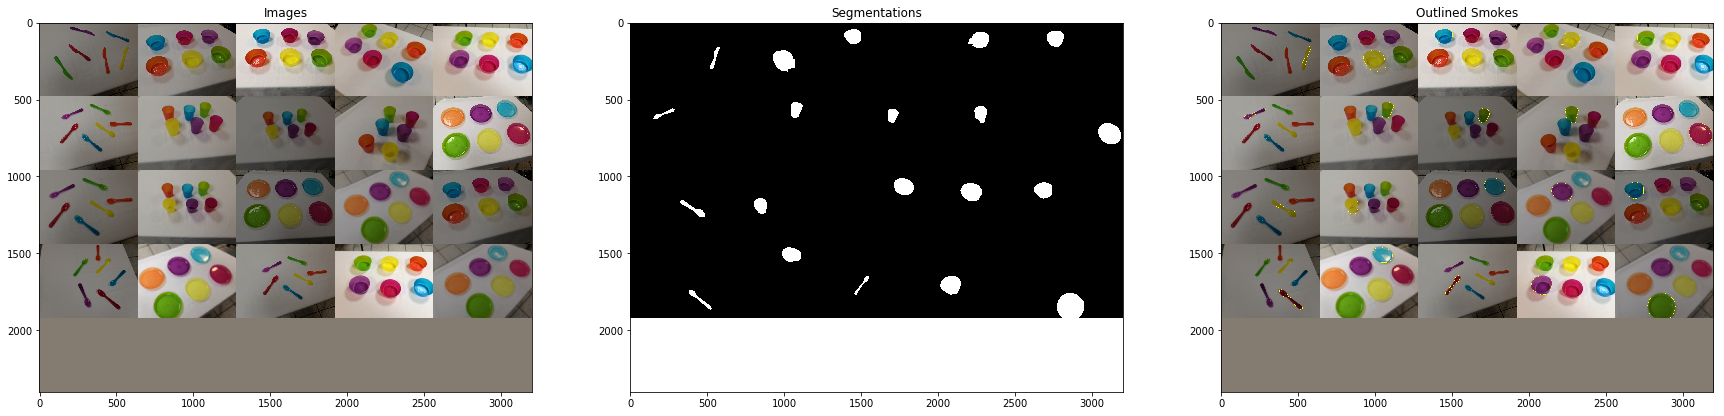

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg, cmap='gray')
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Smokes')
fig.savefig('overview.png')

In [9]:
#valid_x, valid_y, valid_class = next(make_image_gen(TEST_IMGS,len(TEST_IMGS)))
#print(valid_x.shape, valid_y.shape, valid_class)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = False, 
                  vertical_flip = False,
                  fill_mode = 'constant',
                  data_format = 'channels_last',
                  validation_split=0.2)
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y, in_class in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=False)

        yield next(g_x)/255.0, next(g_y), in_class

Using TensorFlow backend.


In [11]:
cur_gen = create_aug_gen(train_gen)
count = 0

t_x = []
t_y = []
in_class = []
initCount = 2000000

img_path = os.path.join(train_image_dir,'images')
mask_path = os.path.join(train_image_dir,'annotations')

while True:
#hile initCount == 2000000:
    try:
        t_x, t_y, in_classes = next(cur_gen)
        print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
        print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
        print(in_classes)
        for index in range(len(t_x)):
            imsave(os.path.join(img_path, str(initCount) + ".png"), t_x[index])
            imsave(os.path.join(mask_path, str(initCount) + "-" + in_classes[index] + "-0.png"),t_y[:, :, :, 0][index])
            initCount += 1
            #imsave("",t_x[0])
        gc.collect()
    except StopIteration:
        break
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke')
#fig.savefig('augmentations.png')
#cur_gen = create_aug_gen(train_gen)
#t_x, t_y = next(cur_gen)
#print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
#print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
#print(len(t_x))
#print(len(t_y))
#print(len(t_y[:, :, :, 0][0]))
#t_x = t_x[:9]
#t_y = t_y[:9]
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
#ax1.imshow(montage_rgb(t_x), cmap='gray')
#ax1.set_title('images2')
#ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray')
#ax2.set_title('smoke2')
#fig.savefig('augmentations.png')

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'bowl', 'glass', 'spoon', 'bowl', 'knife', 'knife', 'fork', 'bowl', 'bowl', 'spoon', 'bowl', 'bowl', 'dish', 'fork', 'bowl', 'dish', 'bowl', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000000-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'bowl', 'bowl', 'glass', 'knife', 'dish', 'bowl', 'bowl', 'knife', 'bowl', 'dish', 'dish', 'fork', 'dish', 'bowl', 'knife', 'glass', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000020-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000021-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000025-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000029-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'bowl', 'bowl', 'spoon', 'spoon', 'spoon', 'dish', 'bowl', 'spoon', 'glass', 'fork', 'dish', 'knife', 'dish', 'fork', 'spoon', 'glass', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000046-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000053-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000055-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'dish', 'fork', 'glass', 'glass', 'fork', 'dish', 'knife', 'fork', 'glass', 'spoon', 'dish', 'dish', 'knife', 'spoon', 'knife', 'spoon', 'bowl', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000062-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000068-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000070-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000074-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'glass', 'bowl', 'bowl', 'knife', 'bowl', 'glass', 'glass', 'dish', 'dish', 'glass', 'dish', 'fork', 'knife', 'fork', 'dish', 'fork', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000081-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000085-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000093-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000094-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'spoon', 'glass', 'dish', 'dish', 'knife', 'dish', 'dish', 'glass', 'knife', 'glass', 'dish', 'glass', 'knife', 'glass', 'dish', 'bowl', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000106-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000110-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000114-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'dish', 'knife', 'fork', 'bowl', 'glass', 'spoon', 'bowl', 'bowl', 'bowl', 'spoon', 'dish', 'bowl', 'glass', 'bowl', 'glass', 'dish', 'glass', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000124-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000131-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'dish', 'glass', 'spoon', 'knife', 'bowl', 'dish', 'dish', 'fork', 'fork', 'bowl', 'dish', 'spoon', 'bowl', 'glass', 'knife', 'fork', 'spoon', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000149-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000156-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000158-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'fork', 'glass', 'dish', 'fork', 'knife', 'dish', 'fork', 'knife', 'spoon', 'spoon', 'fork', 'dish', 'fork', 'bowl', 'fork', 'knife', 'dish', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000161-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000164-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000165-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000167-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bioro

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'spoon', 'spoon', 'dish', 'glass', 'knife', 'glass', 'fork', 'spoon', 'fork', 'fork', 'spoon', 'fork', 'spoon', 'fork', 'knife', 'knife', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000180-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000181-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000183-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000186-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'bowl', 'knife', 'knife', 'bowl', 'knife', 'glass', 'dish', 'knife', 'fork', 'glass', 'knife', 'spoon', 'knife', 'dish', 'spoon', 'bowl', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000201-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000203-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000204-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000206-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'knife', 'fork', 'glass', 'spoon', 'dish', 'dish', 'knife', 'bowl', 'knife', 'dish', 'glass', 'fork', 'dish', 'glass', 'dish', 'glass', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000222-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000223-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000225-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000233-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.99406695)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'dish', 'glass', 'dish', 'dish', 'dish', 'glass', 'bowl', 'bowl', 'spoon', 'dish', 'glass', 'dish', 'bowl', 'dish', 'glass', 'knife', 'fork', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000250-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000257-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000258-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'glass', 'bowl', 'knife', 'glass', 'dish', 'dish', 'knife', 'spoon', 'spoon', 'bowl', 'bowl', 'bowl', 'fork', 'dish', 'bowl', 'fork', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000261-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000264-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000269-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000274-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'knife', 'bowl', 'dish', 'bowl', 'knife', 'bowl', 'fork', 'bowl', 'fork', 'dish', 'dish', 'glass', 'bowl', 'glass', 'fork', 'bowl', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000282-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000290-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'spoon', 'spoon', 'knife', 'spoon', 'knife', 'dish', 'bowl', 'fork', 'bowl', 'bowl', 'spoon', 'bowl', 'spoon', 'bowl', 'bowl', 'dish', 'glass', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000300-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000302-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000304-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000305-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'knife', 'knife', 'fork', 'dish', 'bowl', 'dish', 'knife', 'knife', 'bowl', 'knife', 'glass', 'bowl', 'spoon', 'knife', 'bowl', 'glass', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000322-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000323-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000328-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000329-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'glass', 'knife', 'spoon', 'glass', 'glass', 'bowl', 'knife', 'fork', 'knife', 'dish', 'knife', 'glass', 'fork', 'bowl', 'spoon', 'knife', 'spoon', 'spoon', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000340-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000342-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000347-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000348-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'knife', 'bowl', 'spoon', 'bowl', 'glass', 'spoon', 'bowl', 'dish', 'spoon', 'bowl', 'glass', 'fork', 'knife', 'fork', 'knife', 'dish', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000362-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000370-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000373-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000374-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'spoon', 'dish', 'dish', 'spoon', 'bowl', 'glass', 'spoon', 'fork', 'knife', 'glass', 'fork', 'spoon', 'bowl', 'knife', 'glass', 'dish', 'dish', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000380-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000381-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000384-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000388-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'spoon', 'glass', 'fork', 'spoon', 'bowl', 'dish', 'bowl', 'dish', 'knife', 'spoon', 'spoon', 'glass', 'spoon', 'glass', 'knife', 'knife', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000400-glass-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000401-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000404-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000405-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'bowl', 'bowl', 'dish', 'knife', 'dish', 'fork', 'bowl', 'spoon', 'bowl', 'glass', 'knife', 'dish', 'dish', 'dish', 'fork', 'bowl', 'knife', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000424-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000426-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000431-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000435-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'glass', 'knife', 'fork', 'knife', 'dish', 'knife', 'bowl', 'dish', 'spoon', 'fork', 'dish', 'dish', 'spoon', 'bowl', 'fork', 'knife', 'glass', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000443-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000444-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000446-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000450-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'bowl', 'glass', 'spoon', 'dish', 'spoon', 'dish', 'knife', 'fork', 'knife', 'fork', 'glass', 'fork', 'dish', 'fork', 'dish', 'bowl', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000466-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000473-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000474-dish-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000475-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'spoon', 'glass', 'dish', 'glass', 'spoon', 'bowl', 'dish', 'bowl', 'knife', 'fork', 'spoon', 'bowl', 'knife', 'bowl', 'glass', 'spoon', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000481-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000482-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000491-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000497-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'glass', 'bowl', 'knife', 'fork', 'bowl', 'fork', 'bowl', 'knife', 'spoon', 'knife', 'fork', 'dish', 'fork', 'bowl', 'bowl', 'knife', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000504-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000509-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000514-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000517-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'glass', 'fork', 'fork', 'knife', 'dish', 'fork', 'spoon', 'bowl', 'glass', 'bowl', 'dish', 'knife', 'glass', 'dish', 'dish', 'glass', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000521-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000523-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000524-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000525-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'glass', 'bowl', 'knife', 'dish', 'dish', 'fork', 'dish', 'knife', 'bowl', 'dish', 'knife', 'dish', 'knife', 'fork', 'dish', 'glass', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000541-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000544-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000549-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000552-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'glass', 'glass', 'bowl', 'knife', 'dish', 'knife', 'dish', 'glass', 'knife', 'glass', 'dish', 'knife', 'spoon', 'glass', 'bowl', 'spoon', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000565-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000567-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000570-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000573-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'glass', 'spoon', 'dish', 'spoon', 'knife', 'dish', 'glass', 'dish', 'fork', 'spoon', 'knife', 'bowl', 'glass', 'dish', 'fork', 'glass', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000581-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000583-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000585-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000586-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'dish', 'fork', 'knife', 'bowl', 'bowl', 'spoon', 'spoon', 'glass', 'fork', 'spoon', 'bowl', 'fork', 'spoon', 'knife', 'spoon', 'bowl', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000603-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000604-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000608-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000614-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'spoon', 'dish', 'knife', 'dish', 'spoon', 'bowl', 'dish', 'bowl', 'spoon', 'bowl', 'spoon', 'dish', 'bowl', 'dish', 'bowl', 'bowl', 'bowl', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000624-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000632-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000639-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'knife', 'dish', 'glass', 'dish', 'knife', 'fork', 'dish', 'spoon', 'dish', 'spoon', 'knife', 'spoon', 'bowl', 'knife', 'spoon', 'fork', 'fork', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000642-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000646-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000647-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000651-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'fork', 'bowl', 'fork', 'glass', 'dish', 'knife', 'dish', 'glass', 'glass', 'knife', 'bowl', 'dish', 'bowl', 'bowl', 'knife', 'knife', 'dish', 'glass', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000661-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000666-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000670-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000675-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'dish', 'dish', 'dish', 'knife', 'spoon', 'glass', 'spoon', 'knife', 'spoon', 'dish', 'bowl', 'fork', 'fork', 'bowl', 'bowl', 'bowl', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000680-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000681-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000685-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000694-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'bowl', 'spoon', 'knife', 'knife', 'knife', 'knife', 'knife', 'dish', 'glass', 'spoon', 'spoon', 'dish', 'knife', 'glass', 'bowl', 'knife', 'knife', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000700-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000706-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000707-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000711-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'dish', 'glass', 'knife', 'bowl', 'bowl', 'spoon', 'dish', 'dish', 'knife', 'fork', 'dish', 'knife', 'knife', 'spoon', 'knife', 'knife', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000721-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000724-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000730-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000731-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'spoon', 'spoon', 'glass', 'bowl', 'fork', 'knife', 'bowl', 'spoon', 'bowl', 'glass', 'dish', 'knife', 'knife', 'dish', 'fork', 'knife', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000740-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000742-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000746-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000747-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'fork', 'bowl', 'dish', 'glass', 'fork', 'spoon', 'knife', 'fork', 'fork', 'glass', 'fork', 'fork', 'spoon', 'glass', 'glass', 'dish', 'spoon', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000762-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000766-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000769-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000772-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorob

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'dish', 'dish', 'dish', 'fork', 'dish', 'bowl', 'dish', 'glass', 'spoon', 'spoon', 'dish', 'knife', 'bowl', 'spoon', 'dish', 'bowl', 'spoon', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000785-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000793-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000795-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000799-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'glass', 'knife', 'knife', 'knife', 'knife', 'glass', 'dish', 'glass', 'glass', 'knife', 'glass', 'bowl', 'spoon', 'knife', 'spoon', 'spoon', 'glass', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000803-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000804-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000805-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000806-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'spoon', 'dish', 'dish', 'dish', 'glass', 'glass', 'glass', 'bowl', 'glass', 'fork', 'bowl', 'spoon', 'knife', 'knife', 'knife', 'spoon', 'glass', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000820-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000822-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000834-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000835-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'knife', 'bowl', 'dish', 'glass', 'dish', 'knife', 'dish', 'spoon', 'glass', 'glass', 'spoon', 'spoon', 'dish', 'bowl', 'dish', 'glass', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000840-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000841-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000842-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000849-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'dish', 'spoon', 'spoon', 'dish', 'bowl', 'knife', 'dish', 'dish', 'spoon', 'bowl', 'bowl', 'bowl', 'bowl', 'spoon', 'dish', 'dish', 'fork', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000861-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000864-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000867-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000875-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'spoon', 'glass', 'knife', 'knife', 'glass', 'knife', 'spoon', 'fork', 'knife', 'bowl', 'dish', 'glass', 'dish', 'spoon', 'glass', 'glass', 'knife', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000880-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000884-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000888-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000895-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'bowl', 'glass', 'spoon', 'dish', 'knife', 'fork', 'fork', 'spoon', 'fork', 'fork', 'bowl', 'knife', 'spoon', 'spoon', 'glass', 'knife', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000904-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000906-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000907-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000910-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'glass', 'spoon', 'fork', 'fork', 'bowl', 'glass', 'dish', 'knife', 'knife', 'knife', 'spoon', 'dish', 'bowl', 'spoon', 'bowl', 'bowl', 'fork', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000920-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000923-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000924-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000928-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.99274147)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'spoon', 'spoon', 'glass', 'bowl', 'fork', 'glass', 'bowl', 'bowl', 'spoon', 'fork', 'knife', 'dish', 'glass', 'bowl', 'bowl', 'bowl', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000940-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000946-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000950-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000951-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'glass', 'fork', 'dish', 'glass', 'spoon', 'knife', 'spoon', 'bowl', 'glass', 'knife', 'knife', 'knife', 'glass', 'glass', 'spoon', 'fork', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000963-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000967-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000971-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000977-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'glass', 'dish', 'spoon', 'spoon', 'knife', 'knife', 'knife', 'bowl', 'bowl', 'bowl', 'knife', 'dish', 'dish', 'fork', 'knife', 'dish', 'bowl', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000984-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000987-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000988-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2000992-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'spoon', 'bowl', 'glass', 'glass', 'fork', 'knife', 'dish', 'knife', 'knife', 'knife', 'bowl', 'glass', 'knife', 'bowl', 'spoon', 'spoon', 'fork', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001000-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001001-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001006-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001007-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'dish', 'spoon', 'knife', 'fork', 'dish', 'glass', 'spoon', 'dish', 'knife', 'dish', 'bowl', 'fork', 'dish', 'knife', 'knife', 'knife', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001020-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001024-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001030-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001033-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'bowl', 'dish', 'spoon', 'spoon', 'spoon', 'knife', 'bowl', 'bowl', 'knife', 'spoon', 'fork', 'dish', 'dish', 'knife', 'fork', 'fork', 'dish', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001040-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001044-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001046-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001049-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'spoon', 'spoon', 'spoon', 'glass', 'bowl', 'dish', 'knife', 'glass', 'spoon', 'bowl', 'bowl', 'knife', 'spoon', 'bowl', 'fork', 'dish', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001068-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001073-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001074-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001076-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'glass', 'spoon', 'dish', 'dish', 'fork', 'bowl', 'dish', 'knife', 'dish', 'bowl', 'spoon', 'knife', 'knife', 'bowl', 'glass', 'knife', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001080-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001081-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001083-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001086-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'dish', 'dish', 'spoon', 'bowl', 'spoon', 'spoon', 'knife', 'knife', 'glass', 'spoon', 'dish', 'bowl', 'spoon', 'fork', 'dish', 'spoon', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001104-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001106-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001108-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001111-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'dish', 'fork', 'knife', 'knife', 'spoon', 'dish', 'dish', 'knife', 'dish', 'dish', 'knife', 'spoon', 'glass', 'knife', 'spoon', 'spoon', 'glass', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001120-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001121-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001124-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001125-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'knife', 'glass', 'knife', 'glass', 'dish', 'knife', 'bowl', 'knife', 'dish', 'dish', 'glass', 'dish', 'knife', 'knife', 'glass', 'knife', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001141-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001142-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001144-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001147-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'glass', 'bowl', 'bowl', 'knife', 'knife', 'glass', 'dish', 'spoon', 'knife', 'glass', 'glass', 'glass', 'spoon', 'dish', 'knife', 'spoon', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001165-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001166-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001169-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001170-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'glass', 'glass', 'dish', 'fork', 'dish', 'glass', 'glass', 'dish', 'spoon', 'fork', 'bowl', 'spoon', 'spoon', 'knife', 'dish', 'knife', 'dish', 'fork', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001184-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001190-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001193-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001194-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'dish', 'spoon', 'spoon', 'bowl', 'bowl', 'spoon', 'spoon', 'bowl', 'bowl', 'dish', 'dish', 'glass', 'glass', 'glass', 'spoon', 'fork', 'dish', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001203-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001206-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001219-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'spoon', 'knife', 'knife', 'knife', 'glass', 'fork', 'spoon', 'spoon', 'glass', 'glass', 'glass', 'fork', 'fork', 'glass', 'glass', 'dish', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001225-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001233-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001234-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001238-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'glass', 'dish', 'spoon', 'dish', 'spoon', 'spoon', 'bowl', 'glass', 'dish', 'dish', 'bowl', 'fork', 'dish', 'glass', 'fork', 'knife', 'fork', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001246-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001247-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001253-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001256-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'spoon', 'knife', 'knife', 'knife', 'glass', 'fork', 'dish', 'fork', 'knife', 'fork', 'dish', 'glass', 'knife', 'bowl', 'dish', 'fork', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001263-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001264-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001265-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001270-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'dish', 'bowl', 'fork', 'spoon', 'glass', 'dish', 'dish', 'knife', 'fork', 'spoon', 'spoon', 'bowl', 'glass', 'bowl', 'fork', 'spoon', 'glass', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001284-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001289-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001290-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001291-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'spoon', 'dish', 'bowl', 'spoon', 'knife', 'dish', 'knife', 'bowl', 'bowl', 'knife', 'bowl', 'glass', 'fork', 'dish', 'dish', 'bowl', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001300-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001301-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001302-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001306-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'dish', 'knife', 'fork', 'spoon', 'bowl', 'spoon', 'spoon', 'glass', 'dish', 'knife', 'knife', 'glass', 'spoon', 'spoon', 'glass', 'fork', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001323-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001325-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001327-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001331-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'spoon', 'glass', 'glass', 'dish', 'glass', 'dish', 'glass', 'knife', 'dish', 'fork', 'fork', 'glass', 'glass', 'knife', 'bowl', 'bowl', 'bowl', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001341-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001348-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001350-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001351-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'bowl', 'bowl', 'fork', 'knife', 'knife', 'fork', 'bowl', 'glass', 'spoon', 'dish', 'dish', 'knife', 'dish', 'fork', 'knife', 'spoon', 'bowl', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001360-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001361-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001364-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001365-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'spoon', 'bowl', 'spoon', 'spoon', 'spoon', 'bowl', 'dish', 'glass', 'dish', 'bowl', 'dish', 'dish', 'bowl', 'bowl', 'spoon', 'dish', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001382-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001385-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001396-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'spoon', 'glass', 'fork', 'bowl', 'knife', 'bowl', 'bowl', 'glass', 'dish', 'knife', 'knife', 'spoon', 'spoon', 'dish', 'dish', 'bowl', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001402-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001404-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001411-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001412-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'knife', 'fork', 'fork', 'glass', 'dish', 'spoon', 'bowl', 'fork', 'spoon', 'dish', 'dish', 'bowl', 'glass', 'spoon', 'spoon', 'spoon', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001420-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001422-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001424-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001429-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'dish', 'spoon', 'glass', 'knife', 'dish', 'knife', 'dish', 'bowl', 'dish', 'dish', 'glass', 'dish', 'knife', 'dish', 'knife', 'spoon', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001440-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001445-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001454-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'bowl', 'bowl', 'dish', 'fork', 'knife', 'glass', 'dish', 'knife', 'glass', 'bowl', 'spoon', 'knife', 'spoon', 'knife', 'bowl', 'knife', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001460-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001465-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001466-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001469-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'spoon', 'fork', 'spoon', 'glass', 'knife', 'spoon', 'bowl', 'bowl', 'bowl', 'dish', 'dish', 'fork', 'spoon', 'bowl', 'knife', 'knife', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001481-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001483-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001486-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001487-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'bowl', 'bowl', 'bowl', 'glass', 'fork', 'dish', 'bowl', 'fork', 'glass', 'bowl', 'fork', 'knife', 'dish', 'spoon', 'knife', 'spoon', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001506-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001509-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001516-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001517-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'spoon', 'bowl', 'knife', 'knife', 'fork', 'fork', 'spoon', 'fork', 'bowl', 'knife', 'bowl', 'bowl', 'knife', 'dish', 'fork', 'glass', 'spoon', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001522-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001524-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001525-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001527-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'bowl', 'bowl', 'spoon', 'glass', 'bowl', 'bowl', 'glass', 'bowl', 'glass', 'knife', 'bowl', 'glass', 'knife', 'spoon', 'glass', 'knife', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001544-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001551-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001554-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001555-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'dish', 'glass', 'knife', 'knife', 'fork', 'bowl', 'fork', 'dish', 'knife', 'glass', 'dish', 'fork', 'dish', 'fork', 'spoon', 'fork', 'glass', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001564-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001565-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001570-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001575-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'fork', 'glass', 'knife', 'dish', 'spoon', 'dish', 'knife', 'knife', 'dish', 'spoon', 'fork', 'bowl', 'dish', 'glass', 'dish', 'dish', 'spoon', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001581-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001587-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001588-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'fork', 'bowl', 'dish', 'knife', 'bowl', 'spoon', 'glass', 'dish', 'spoon', 'bowl', 'knife', 'dish', 'knife', 'bowl', 'glass', 'bowl', 'glass', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001601-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001604-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001606-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001609-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'dish', 'glass', 'knife', 'spoon', 'bowl', 'bowl', 'bowl', 'knife', 'glass', 'spoon', 'glass', 'dish', 'knife', 'glass', 'knife', 'spoon', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001625-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001629-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001637-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001639-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'fork', 'dish', 'spoon', 'bowl', 'knife', 'knife', 'dish', 'glass', 'spoon', 'bowl', 'bowl', 'dish', 'fork', 'knife', 'bowl', 'fork', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001641-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001646-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001647-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001650-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'bowl', 'knife', 'bowl', 'spoon', 'glass', 'fork', 'knife', 'spoon', 'bowl', 'knife', 'glass', 'spoon', 'knife', 'glass', 'glass', 'dish', 'spoon', 'knife', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001660-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001662-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001667-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001670-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'bowl', 'fork', 'bowl', 'spoon', 'bowl', 'bowl', 'knife', 'bowl', 'dish', 'dish', 'spoon', 'glass', 'glass', 'fork', 'bowl', 'knife', 'spoon', 'knife', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001680-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001682-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001684-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001687-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'glass', 'dish', 'knife', 'knife', 'knife', 'knife', 'knife', 'bowl', 'dish', 'spoon', 'dish', 'knife', 'glass', 'knife', 'fork', 'spoon', 'spoon', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001704-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001707-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001708-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001713-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'glass', 'knife', 'fork', 'knife', 'glass', 'glass', 'dish', 'dish', 'bowl', 'dish', 'bowl', 'glass', 'knife', 'dish', 'knife', 'bowl', 'knife', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001720-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001722-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001724-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001735-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'glass', 'fork', 'knife', 'dish', 'spoon', 'bowl', 'spoon', 'knife', 'fork', 'knife', 'fork', 'fork', 'spoon', 'fork', 'glass', 'glass', 'bowl', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001743-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001747-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001749-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001750-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'fork', 'bowl', 'knife', 'dish', 'bowl', 'bowl', 'spoon', 'knife', 'spoon', 'knife', 'glass', 'knife', 'knife', 'spoon', 'spoon', 'spoon', 'fork', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001760-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001769-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001770-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001772-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'glass', 'bowl', 'glass', 'bowl', 'dish', 'spoon', 'spoon', 'glass', 'bowl', 'bowl', 'glass', 'spoon', 'spoon', 'spoon', 'spoon', 'dish', 'glass', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001781-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001788-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'spoon', 'bowl', 'spoon', 'knife', 'dish', 'bowl', 'glass', 'dish', 'fork', 'glass', 'bowl', 'bowl', 'spoon', 'spoon', 'glass', 'bowl', 'fork', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001802-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001805-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001815-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001818-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'fork', 'knife', 'bowl', 'dish', 'bowl', 'spoon', 'bowl', 'glass', 'knife', 'dish', 'dish', 'spoon', 'knife', 'glass', 'glass', 'dish', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001827-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001830-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'dish', 'dish', 'dish', 'glass', 'spoon', 'bowl', 'bowl', 'fork', 'spoon', 'spoon', 'knife', 'bowl', 'knife', 'spoon', 'bowl', 'spoon', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001849-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001855-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001857-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'fork', 'fork', 'dish', 'knife', 'fork', 'knife', 'spoon', 'bowl', 'spoon', 'bowl', 'knife', 'glass', 'knife', 'dish', 'fork', 'bowl', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001865-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001867-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001872-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001874-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'spoon', 'bowl', 'bowl', 'spoon', 'glass', 'fork', 'fork', 'bowl', 'glass', 'knife', 'bowl', 'dish', 'bowl', 'knife', 'glass', 'bowl', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001887-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001891-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001895-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'bowl', 'knife', 'bowl', 'glass', 'knife', 'bowl', 'dish', 'fork', 'spoon', 'knife', 'fork', 'bowl', 'spoon', 'spoon', 'spoon', 'knife', 'bowl', 'bowl', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001900-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001902-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001905-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001908-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'knife', 'fork', 'spoon', 'dish', 'bowl', 'fork', 'dish', 'spoon', 'fork', 'spoon', 'glass', 'bowl', 'knife', 'knife', 'knife', 'bowl', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001921-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001922-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001930-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001931-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'knife', 'glass', 'fork', 'glass', 'knife', 'glass', 'glass', 'dish', 'bowl', 'bowl', 'spoon', 'spoon', 'glass', 'glass', 'knife', 'dish', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001941-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001952-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001953-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001956-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'fork', 'spoon', 'spoon', 'knife', 'knife', 'spoon', 'spoon', 'spoon', 'bowl', 'dish', 'spoon', 'glass', 'spoon', 'glass', 'bowl', 'fork', 'dish', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001961-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001963-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001964-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001965-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'knife', 'knife', 'bowl', 'dish', 'spoon', 'fork', 'knife', 'fork', 'glass', 'spoon', 'glass', 'spoon', 'knife', 'spoon', 'knife', 'spoon', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001982-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001988-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001989-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2001991-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'fork', 'glass', 'knife', 'spoon', 'spoon', 'knife', 'dish', 'glass', 'dish', 'dish', 'fork', 'glass', 'spoon', 'glass', 'dish', 'bowl', 'knife', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002005-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002006-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002011-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002017-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'glass', 'dish', 'glass', 'bowl', 'glass', 'fork', 'dish', 'fork', 'glass', 'knife', 'glass', 'bowl', 'knife', 'knife', 'spoon', 'bowl', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002031-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002034-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002035-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002038-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'knife', 'bowl', 'knife', 'bowl', 'spoon', 'knife', 'dish', 'bowl', 'dish', 'dish', 'spoon', 'glass', 'bowl', 'bowl', 'dish', 'spoon', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002044-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002047-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002052-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002057-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'glass', 'bowl', 'spoon', 'dish', 'spoon', 'knife', 'spoon', 'bowl', 'spoon', 'glass', 'fork', 'bowl', 'bowl', 'fork', 'spoon', 'knife', 'knife', 'spoon', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002066-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002069-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002071-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002074-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'spoon', 'dish', 'fork', 'spoon', 'dish', 'spoon', 'knife', 'fork', 'bowl', 'dish', 'dish', 'knife', 'knife', 'dish', 'knife', 'glass', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002082-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002084-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002085-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002087-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'dish', 'spoon', 'knife', 'spoon', 'spoon', 'spoon', 'bowl', 'dish', 'bowl', 'fork', 'spoon', 'dish', 'glass', 'spoon', 'dish', 'glass', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002103-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002104-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002106-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002111-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'dish', 'knife', 'knife', 'dish', 'dish', 'fork', 'dish', 'dish', 'spoon', 'knife', 'knife', 'knife', 'fork', 'spoon', 'fork', 'fork', 'knife', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002122-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002123-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002126-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002129-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'dish', 'spoon', 'fork', 'bowl', 'dish', 'fork', 'dish', 'dish', 'bowl', 'spoon', 'spoon', 'knife', 'dish', 'spoon', 'glass', 'spoon', 'dish', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002142-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002146-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002150-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002152-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'knife', 'bowl', 'fork', 'dish', 'fork', 'bowl', 'fork', 'glass', 'fork', 'glass', 'dish', 'knife', 'bowl', 'glass', 'spoon', 'spoon', 'fork', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002162-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002168-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002173-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'dish', 'spoon', 'knife', 'dish', 'dish', 'knife', 'glass', 'dish', 'knife', 'knife', 'bowl', 'bowl', 'dish', 'knife', 'bowl', 'bowl', 'knife', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002181-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002190-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002191-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002195-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'fork', 'dish', 'fork', 'knife', 'bowl', 'bowl', 'knife', 'dish', 'bowl', 'glass', 'spoon', 'fork', 'knife', 'bowl', 'dish', 'glass', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002202-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002204-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'spoon', 'spoon', 'glass', 'dish', 'glass', 'fork', 'fork', 'dish', 'spoon', 'dish', 'bowl', 'dish', 'dish', 'dish', 'dish', 'fork', 'dish', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002220-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002227-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'spoon', 'spoon', 'bowl', 'glass', 'spoon', 'spoon', 'bowl', 'fork', 'dish', 'spoon', 'glass', 'dish', 'dish', 'glass', 'knife', 'spoon', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002240-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002243-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002246-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002249-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'spoon', 'glass', 'dish', 'dish', 'fork', 'fork', 'dish', 'knife', 'spoon', 'spoon', 'dish', 'bowl', 'glass', 'knife', 'dish', 'spoon', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002269-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002275-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002277-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'glass', 'bowl', 'bowl', 'knife', 'dish', 'bowl', 'spoon', 'bowl', 'spoon', 'spoon', 'dish', 'dish', 'knife', 'glass', 'glass', 'dish', 'glass', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002280-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002284-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002290-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002293-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'fork', 'knife', 'glass', 'fork', 'bowl', 'bowl', 'glass', 'dish', 'dish', 'spoon', 'dish', 'knife', 'spoon', 'bowl', 'dish', 'knife', 'bowl', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002300-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002301-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002312-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'glass', 'knife', 'knife', 'knife', 'bowl', 'spoon', 'knife', 'dish', 'spoon', 'knife', 'dish', 'fork', 'dish', 'dish', 'bowl', 'dish', 'spoon', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002323-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002324-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002326-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002332-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'spoon', 'bowl', 'dish', 'glass', 'knife', 'spoon', 'bowl', 'fork', 'glass', 'dish', 'knife', 'bowl', 'bowl', 'spoon', 'dish', 'dish', 'spoon', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002341-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002346-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002349-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002352-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.9444488)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'dish', 'fork', 'bowl', 'bowl', 'spoon', 'glass', 'dish', 'bowl', 'dish', 'bowl', 'dish', 'dish', 'dish', 'glass', 'bowl', 'knife', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002363-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002377-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002378-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'fork', 'glass', 'fork', 'knife', 'glass', 'bowl', 'dish', 'spoon', 'glass', 'dish', 'fork', 'knife', 'bowl', 'fork', 'fork', 'spoon', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002380-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002381-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002382-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002385-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'fork', 'bowl', 'fork', 'dish', 'bowl', 'knife', 'bowl', 'glass', 'knife', 'dish', 'bowl', 'dish', 'glass', 'dish', 'dish', 'dish', 'knife', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002401-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002403-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002409-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002417-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'dish', 'fork', 'glass', 'knife', 'glass', 'knife', 'dish', 'dish', 'knife', 'fork', 'bowl', 'dish', 'knife', 'spoon', 'spoon', 'dish', 'dish', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002422-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002424-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002429-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002430-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'glass', 'knife', 'bowl', 'dish', 'knife', 'bowl', 'bowl', 'knife', 'fork', 'bowl', 'bowl', 'fork', 'fork', 'bowl', 'fork', 'spoon', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002441-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002443-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002446-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002449-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'glass', 'knife', 'dish', 'knife', 'dish', 'glass', 'dish', 'spoon', 'knife', 'knife', 'glass', 'spoon', 'knife', 'dish', 'spoon', 'glass', 'bowl', 'spoon', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002462-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002464-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002468-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002469-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.91644806)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'bowl', 'glass', 'knife', 'bowl', 'glass', 'bowl', 'glass', 'fork', 'knife', 'glass', 'glass', 'dish', 'glass', 'bowl', 'dish', 'knife', 'fork', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002480-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002483-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002489-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002496-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'spoon', 'knife', 'glass', 'bowl', 'spoon', 'fork', 'dish', 'bowl', 'dish', 'fork', 'bowl', 'glass', 'bowl', 'glass', 'spoon', 'dish', 'bowl', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002500-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002501-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002502-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002505-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'dish', 'knife', 'spoon', 'spoon', 'glass', 'bowl', 'knife', 'knife', 'glass', 'bowl', 'spoon', 'dish', 'fork', 'dish', 'knife', 'knife', 'bowl', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002520-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002522-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002523-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002524-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'spoon', 'glass', 'bowl', 'spoon', 'dish', 'knife', 'knife', 'spoon', 'bowl', 'glass', 'dish', 'glass', 'bowl', 'spoon', 'glass', 'knife', 'glass', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002540-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002545-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002547-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002548-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'spoon', 'knife', 'dish', 'dish', 'dish', 'spoon', 'glass', 'fork', 'knife', 'dish', 'knife', 'dish', 'glass', 'glass', 'knife', 'spoon', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002562-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002563-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002569-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002570-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'dish', 'dish', 'bowl', 'glass', 'dish', 'spoon', 'glass', 'knife', 'glass', 'dish', 'glass', 'glass', 'dish', 'knife', 'knife', 'knife', 'knife', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002587-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002589-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002595-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002596-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'fork', 'spoon', 'spoon', 'spoon', 'bowl', 'dish', 'glass', 'spoon', 'bowl', 'spoon', 'glass', 'knife', 'knife', 'knife', 'dish', 'spoon', 'bowl', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002601-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002604-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002608-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002612-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'spoon', 'bowl', 'fork', 'dish', 'fork', 'knife', 'spoon', 'knife', 'glass', 'dish', 'glass', 'spoon', 'glass', 'glass', 'fork', 'bowl', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002626-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002633-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002636-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'dish', 'dish', 'glass', 'fork', 'glass', 'glass', 'fork', 'spoon', 'bowl', 'glass', 'knife', 'knife', 'knife', 'bowl', 'dish', 'fork', 'bowl', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002647-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002651-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002653-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002656-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'dish', 'fork', 'bowl', 'knife', 'dish', 'glass', 'bowl', 'knife', 'bowl', 'fork', 'dish', 'knife', 'bowl', 'fork', 'bowl', 'glass', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002660-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002661-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002663-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002665-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.9994885)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'spoon', 'knife', 'knife', 'fork', 'glass', 'glass', 'bowl', 'dish', 'dish', 'glass', 'dish', 'glass', 'glass', 'dish', 'bowl', 'bowl', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002682-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002683-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002684-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002685-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'glass', 'spoon', 'bowl', 'spoon', 'knife', 'dish', 'fork', 'dish', 'bowl', 'fork', 'fork', 'spoon', 'glass', 'dish', 'knife', 'glass', 'fork', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002704-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002705-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002707-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002710-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'dish', 'dish', 'knife', 'spoon', 'spoon', 'glass', 'spoon', 'spoon', 'glass', 'knife', 'fork', 'dish', 'knife', 'glass', 'spoon', 'bowl', 'knife', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002721-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002724-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002725-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002728-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'glass', 'fork', 'bowl', 'spoon', 'spoon', 'dish', 'knife', 'bowl', 'knife', 'bowl', 'knife', 'glass', 'glass', 'glass', 'knife', 'fork', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002743-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002745-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002748-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002750-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'spoon', 'spoon', 'spoon', 'spoon', 'spoon', 'knife', 'dish', 'fork', 'dish', 'spoon', 'glass', 'dish', 'knife', 'knife', 'knife', 'bowl', 'dish', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002760-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002763-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002764-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002766-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'glass', 'spoon', 'knife', 'knife', 'spoon', 'dish', 'fork', 'spoon', 'bowl', 'spoon', 'dish', 'glass', 'bowl', 'knife', 'spoon', 'knife', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002783-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002784-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002785-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002786-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'glass', 'spoon', 'glass', 'bowl', 'spoon', 'fork', 'bowl', 'spoon', 'bowl', 'spoon', 'bowl', 'spoon', 'bowl', 'knife', 'dish', 'spoon', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002803-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002807-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002809-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002815-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'dish', 'dish', 'spoon', 'bowl', 'spoon', 'knife', 'knife', 'spoon', 'dish', 'dish', 'spoon', 'spoon', 'glass', 'dish', 'glass', 'dish', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002827-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002829-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002832-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002833-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'glass', 'knife', 'spoon', 'dish', 'fork', 'dish', 'knife', 'glass', 'bowl', 'spoon', 'knife', 'spoon', 'glass', 'bowl', 'knife', 'bowl', 'fork', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002842-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002845-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002847-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002850-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'glass', 'bowl', 'knife', 'bowl', 'knife', 'dish', 'glass', 'knife', 'bowl', 'dish', 'fork', 'fork', 'dish', 'fork', 'spoon', 'bowl', 'glass', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002860-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002863-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002868-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002871-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'bowl', 'glass', 'dish', 'bowl', 'glass', 'dish', 'glass', 'bowl', 'knife', 'glass', 'fork', 'glass', 'spoon', 'fork', 'knife', 'glass', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002890-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002896-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002899-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'dish', 'spoon', 'dish', 'spoon', 'knife', 'glass', 'knife', 'knife', 'knife', 'dish', 'knife', 'knife', 'knife', 'spoon', 'dish', 'dish', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002900-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002901-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002906-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002908-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'knife', 'spoon', 'spoon', 'bowl', 'knife', 'knife', 'bowl', 'bowl', 'glass', 'fork', 'dish', 'glass', 'dish', 'fork', 'bowl', 'dish', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002922-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002923-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002924-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002926-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'dish', 'spoon', 'dish', 'glass', 'fork', 'knife', 'dish', 'knife', 'fork', 'glass', 'bowl', 'bowl', 'knife', 'knife', 'glass', 'glass', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002941-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002943-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002947-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002950-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'fork', 'spoon', 'fork', 'knife', 'bowl', 'bowl', 'spoon', 'bowl', 'bowl', 'knife', 'dish', 'bowl', 'fork', 'glass', 'spoon', 'glass', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002964-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002965-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002968-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'fork', 'bowl', 'dish', 'spoon', 'knife', 'glass', 'glass', 'bowl', 'knife', 'bowl', 'spoon', 'bowl', 'dish', 'dish', 'bowl', 'knife', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002980-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002982-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002990-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2002999-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'glass', 'bowl', 'glass', 'knife', 'dish', 'glass', 'spoon', 'dish', 'knife', 'bowl', 'knife', 'glass', 'fork', 'spoon', 'glass', 'bowl', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003001-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003005-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003012-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'dish', 'dish', 'knife', 'knife', 'dish', 'knife', 'knife', 'knife', 'bowl', 'dish', 'knife', 'spoon', 'knife', 'knife', 'spoon', 'spoon', 'fork', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003021-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003027-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003029-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003032-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'knife', 'dish', 'bowl', 'fork', 'glass', 'dish', 'dish', 'dish', 'bowl', 'spoon', 'fork', 'dish', 'bowl', 'dish', 'dish', 'dish', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003040-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003041-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003045-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003052-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'spoon', 'glass', 'knife', 'dish', 'glass', 'bowl', 'spoon', 'dish', 'glass', 'spoon', 'glass', 'spoon', 'knife', 'knife', 'dish', 'bowl', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003061-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003068-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003071-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003075-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'bowl', 'dish', 'spoon', 'knife', 'knife', 'bowl', 'dish', 'knife', 'dish', 'knife', 'bowl', 'spoon', 'knife', 'spoon', 'bowl', 'dish', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003085-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003086-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003089-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003091-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'glass', 'glass', 'knife', 'fork', 'spoon', 'dish', 'fork', 'fork', 'bowl', 'glass', 'bowl', 'bowl', 'dish', 'dish', 'fork', 'glass', 'knife', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003104-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003105-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003108-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003115-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bioro

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'spoon', 'glass', 'glass', 'dish', 'knife', 'dish', 'fork', 'dish', 'spoon', 'bowl', 'spoon', 'glass', 'spoon', 'spoon', 'glass', 'bowl', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003126-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003128-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003132-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003138-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'fork', 'dish', 'knife', 'dish', 'dish', 'knife', 'glass', 'spoon', 'bowl', 'glass', 'bowl', 'glass', 'glass', 'dish', 'bowl', 'dish', 'knife', 'knife', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003143-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003146-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003148-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003157-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'dish', 'bowl', 'spoon', 'dish', 'spoon', 'fork', 'spoon', 'dish', 'glass', 'knife', 'spoon', 'knife', 'dish', 'fork', 'dish', 'fork', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003164-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003166-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003171-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003173-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'bowl', 'glass', 'spoon', 'spoon', 'knife', 'knife', 'spoon', 'dish', 'dish', 'glass', 'knife', 'knife', 'knife', 'glass', 'knife', 'fork', 'fork', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003185-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003186-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003187-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003188-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'fork', 'dish', 'glass', 'glass', 'knife', 'dish', 'knife', 'dish', 'glass', 'dish', 'dish', 'spoon', 'knife', 'fork', 'bowl', 'knife', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003202-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003206-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003208-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003215-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'glass', 'knife', 'bowl', 'bowl', 'bowl', 'fork', 'bowl', 'bowl', 'knife', 'dish', 'fork', 'glass', 'bowl', 'spoon', 'spoon', 'dish', 'knife', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003223-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003227-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003230-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003232-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'fork', 'spoon', 'bowl', 'spoon', 'spoon', 'knife', 'spoon', 'bowl', 'dish', 'bowl', 'knife', 'bowl', 'knife', 'knife', 'spoon', 'glass', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003242-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003243-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003245-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003247-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'dish', 'bowl', 'dish', 'spoon', 'glass', 'dish', 'bowl', 'knife', 'knife', 'bowl', 'spoon', 'spoon', 'dish', 'bowl', 'dish', 'knife', 'glass', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003264-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003268-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003269-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'dish', 'bowl', 'bowl', 'bowl', 'knife', 'bowl', 'spoon', 'dish', 'fork', 'spoon', 'dish', 'knife', 'knife', 'glass', 'bowl', 'bowl', 'fork', 'spoon', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003285-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003289-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003292-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003293-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'bowl', 'dish', 'dish', 'fork', 'spoon', 'knife', 'dish', 'glass', 'dish', 'spoon', 'bowl', 'bowl', 'knife', 'fork', 'fork', 'glass', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003305-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003307-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003315-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003318-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'spoon', 'glass', 'dish', 'knife', 'dish', 'bowl', 'spoon', 'fork', 'knife', 'dish', 'knife', 'knife', 'glass', 'spoon', 'bowl', 'bowl', 'fork', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003320-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003321-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003328-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003329-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'fork', 'fork', 'spoon', 'dish', 'glass', 'spoon', 'bowl', 'spoon', 'glass', 'knife', 'knife', 'spoon', 'bowl', 'spoon', 'glass', 'spoon', 'bowl', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003343-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003347-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003351-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003352-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'dish', 'dish', 'dish', 'dish', 'knife', 'knife', 'glass', 'glass', 'dish', 'spoon', 'knife', 'dish', 'knife', 'bowl', 'spoon', 'fork', 'fork', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003366-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003367-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003372-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003374-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'spoon', 'knife', 'dish', 'spoon', 'glass', 'glass', 'spoon', 'dish', 'spoon', 'glass', 'glass', 'spoon', 'knife', 'bowl', 'knife', 'knife', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003382-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003383-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003388-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003390-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'knife', 'dish', 'fork', 'spoon', 'fork', 'spoon', 'glass', 'bowl', 'spoon', 'glass', 'glass', 'dish', 'knife', 'spoon', 'fork', 'spoon', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003400-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003405-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003406-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003407-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'glass', 'glass', 'glass', 'knife', 'knife', 'bowl', 'knife', 'dish', 'dish', 'glass', 'glass', 'dish', 'bowl', 'spoon', 'bowl', 'bowl', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003421-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003425-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003426-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003428-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'glass', 'glass', 'glass', 'glass', 'dish', 'dish', 'dish', 'dish', 'glass', 'dish', 'knife', 'dish', 'spoon', 'spoon', 'knife', 'bowl', 'fork', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003440-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003441-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003452-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003455-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'spoon', 'knife', 'dish', 'bowl', 'knife', 'bowl', 'knife', 'glass', 'glass', 'bowl', 'bowl', 'spoon', 'fork', 'fork', 'dish', 'glass', 'knife', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003462-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003466-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003468-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'bowl', 'knife', 'bowl', 'knife', 'dish', 'spoon', 'knife', 'dish', 'bowl', 'bowl', 'knife', 'knife', 'dish', 'glass', 'knife', 'glass', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003483-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003485-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003487-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003493-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'bowl', 'fork', 'bowl', 'knife', 'dish', 'knife', 'spoon', 'bowl', 'bowl', 'glass', 'glass', 'dish', 'knife', 'glass', 'bowl', 'knife', 'glass', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003502-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003504-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003506-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003507-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'dish', 'spoon', 'fork', 'bowl', 'glass', 'knife', 'dish', 'glass', 'knife', 'knife', 'dish', 'glass', 'spoon', 'dish', 'dish', 'knife', 'glass', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003521-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003527-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003531-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003537-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'glass', 'spoon', 'spoon', 'knife', 'dish', 'knife', 'spoon', 'dish', 'glass', 'glass', 'bowl', 'dish', 'bowl', 'bowl', 'dish', 'dish', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003547-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'fork', 'knife', 'dish', 'bowl', 'glass', 'glass', 'bowl', 'bowl', 'glass', 'knife', 'glass', 'knife', 'fork', 'knife', 'bowl', 'dish', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003562-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003571-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003573-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003574-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'fork', 'spoon', 'dish', 'glass', 'knife', 'knife', 'dish', 'knife', 'knife', 'dish', 'dish', 'knife', 'spoon', 'dish', 'glass', 'glass', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003581-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003582-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003583-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003586-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'dish', 'glass', 'knife', 'glass', 'glass', 'knife', 'bowl', 'bowl', 'knife', 'dish', 'knife', 'dish', 'spoon', 'knife', 'bowl', 'dish', 'fork', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003603-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003606-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003609-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003613-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'knife', 'spoon', 'dish', 'dish', 'glass', 'glass', 'fork', 'bowl', 'fork', 'spoon', 'bowl', 'spoon', 'spoon', 'fork', 'bowl', 'spoon', 'dish', 'fork', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003627-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003629-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003630-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003632-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'fork', 'dish', 'glass', 'spoon', 'dish', 'bowl', 'knife', 'glass', 'bowl', 'knife', 'fork', 'spoon', 'spoon', 'glass', 'knife', 'glass', 'glass', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003640-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003644-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003647-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003655-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'spoon', 'spoon', 'dish', 'spoon', 'glass', 'glass', 'glass', 'spoon', 'dish', 'knife', 'glass', 'dish', 'glass', 'dish', 'glass', 'glass', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003661-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003662-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003669-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'spoon', 'knife', 'spoon', 'fork', 'spoon', 'spoon', 'spoon', 'glass', 'bowl', 'fork', 'bowl', 'bowl', 'bowl', 'knife', 'fork', 'bowl', 'spoon', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003682-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003686-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003694-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003695-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'glass', 'glass', 'glass', 'glass', 'spoon', 'spoon', 'dish', 'fork', 'bowl', 'bowl', 'spoon', 'spoon', 'spoon', 'dish', 'knife', 'knife', 'bowl', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003700-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003705-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003706-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003708-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'fork', 'bowl', 'spoon', 'spoon', 'fork', 'dish', 'spoon', 'bowl', 'dish', 'glass', 'knife', 'bowl', 'dish', 'fork', 'bowl', 'fork', 'dish', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003731-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003734-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003736-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003739-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.9539063)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'spoon', 'dish', 'knife', 'dish', 'knife', 'bowl', 'spoon', 'fork', 'glass', 'bowl', 'bowl', 'knife', 'dish', 'glass', 'bowl', 'knife', 'spoon', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003740-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003741-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003743-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003745-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'dish', 'glass', 'spoon', 'dish', 'dish', 'spoon', 'dish', 'dish', 'dish', 'knife', 'dish', 'knife', 'spoon', 'spoon', 'glass', 'spoon', 'fork', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003760-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003763-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003766-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003770-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'glass', 'glass', 'dish', 'knife', 'fork', 'bowl', 'bowl', 'spoon', 'knife', 'dish', 'bowl', 'spoon', 'dish', 'spoon', 'dish', 'knife', 'fork', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003784-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003788-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003789-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003792-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'glass', 'glass', 'knife', 'knife', 'bowl', 'dish', 'glass', 'bowl', 'dish', 'glass', 'glass', 'spoon', 'spoon', 'fork', 'bowl', 'bowl', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003804-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003805-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'glass', 'fork', 'dish', 'spoon', 'dish', 'dish', 'bowl', 'glass', 'fork', 'glass', 'spoon', 'knife', 'dish', 'bowl', 'dish', 'dish', 'glass', 'bowl', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003820-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003822-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003824-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003829-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'fork', 'bowl', 'dish', 'spoon', 'knife', 'glass', 'dish', 'bowl', 'bowl', 'spoon', 'dish', 'glass', 'spoon', 'dish', 'dish', 'fork', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003840-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003841-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003842-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003846-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'glass', 'knife', 'knife', 'glass', 'bowl', 'glass', 'spoon', 'dish', 'knife', 'fork', 'glass', 'dish', 'knife', 'knife', 'bowl', 'dish', 'dish', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003860-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003863-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003870-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003874-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 0.9629513)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'dish', 'dish', 'dish', 'spoon', 'glass', 'glass', 'fork', 'fork', 'glass', 'glass', 'knife', 'bowl', 'dish', 'dish', 'bowl', 'dish', 'knife', 'dish', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003880-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003887-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003891-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003897-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'spoon', 'spoon', 'fork', 'bowl', 'bowl', 'bowl', 'spoon', 'knife', 'knife', 'bowl', 'knife', 'knife', 'knife', 'knife', 'dish', 'dish', 'knife', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003902-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003904-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003913-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003915-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'spoon', 'dish', 'dish', 'dish', 'spoon', 'glass', 'dish', 'spoon', 'spoon', 'knife', 'spoon', 'dish', 'knife', 'glass', 'spoon', 'spoon', 'dish', 'dish', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003920-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003925-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003930-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003931-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'knife', 'bowl', 'dish', 'glass', 'dish', 'bowl', 'dish', 'fork', 'knife', 'knife', 'fork', 'spoon', 'knife', 'knife', 'knife', 'bowl', 'fork', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003942-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003949-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003950-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003951-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'fork', 'knife', 'glass', 'glass', 'bowl', 'dish', 'dish', 'glass', 'spoon', 'fork', 'spoon', 'knife', 'knife', 'dish', 'fork', 'bowl', 'bowl', 'bowl', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003960-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003962-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003970-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003972-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'knife', 'spoon', 'fork', 'knife', 'dish', 'fork', 'knife', 'bowl', 'glass', 'knife', 'knife', 'dish', 'bowl', 'bowl', 'spoon', 'knife', 'bowl', 'spoon', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003981-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003984-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003986-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2003987-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'dish', 'dish', 'fork', 'knife', 'dish', 'fork', 'fork', 'bowl', 'knife', 'spoon', 'bowl', 'bowl', 'fork', 'spoon', 'spoon', 'glass', 'bowl', 'bowl', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004007-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004009-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004010-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004013-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'knife', 'spoon', 'spoon', 'bowl', 'dish', 'bowl', 'dish', 'dish', 'dish', 'bowl', 'glass', 'fork', 'knife', 'spoon', 'glass', 'bowl', 'bowl', 'glass', 'spoon']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004021-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004032-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004034-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004039-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'glass', 'bowl', 'spoon', 'knife', 'spoon', 'glass', 'dish', 'bowl', 'knife', 'knife', 'fork', 'knife', 'fork', 'bowl', 'glass', 'bowl', 'spoon', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004043-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004045-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004049-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004052-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'knife', 'knife', 'bowl', 'spoon', 'spoon', 'glass', 'knife', 'bowl', 'dish', 'dish', 'glass', 'spoon', 'dish', 'fork', 'dish', 'knife', 'glass', 'glass', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004060-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004062-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004065-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004067-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'glass', 'knife', 'bowl', 'knife', 'fork', 'fork', 'knife', 'dish', 'bowl', 'bowl', 'dish', 'knife', 'glass', 'spoon', 'glass', 'knife', 'spoon', 'bowl', 'glass']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004082-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004084-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004085-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004086-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'bowl', 'spoon', 'knife', 'knife', 'bowl', 'spoon', 'dish', 'bowl', 'knife', 'spoon', 'fork', 'knife', 'dish', 'spoon', 'knife', 'fork', 'knife', 'bowl', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004103-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004104-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004106-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004109-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'knife', 'dish', 'spoon', 'bowl', 'spoon', 'knife', 'spoon', 'dish', 'spoon', 'dish', 'spoon', 'dish', 'glass', 'bowl', 'spoon', 'spoon', 'glass', 'glass', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004121-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004123-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004125-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004131-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['fork', 'knife', 'dish', 'spoon', 'knife', 'glass', 'dish', 'knife', 'knife', 'fork', 'dish', 'spoon', 'dish', 'fork', 'knife', 'bowl', 'knife', 'knife', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004140-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004141-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004144-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004149-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'bowl', 'glass', 'fork', 'glass', 'bowl', 'spoon', 'knife', 'glass', 'dish', 'dish', 'spoon', 'spoon', 'bowl', 'glass', 'knife', 'glass', 'bowl', 'spoon', 'knife']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004163-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004166-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004167-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004172-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'fork', 'spoon', 'dish', 'dish', 'spoon', 'knife', 'fork', 'knife', 'bowl', 'fork', 'glass', 'bowl', 'dish', 'dish', 'spoon', 'spoon', 'knife', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004181-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004185-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004186-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004187-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'spoon', 'fork', 'dish', 'knife', 'fork', 'bowl', 'dish', 'spoon', 'bowl', 'knife', 'spoon', 'dish', 'dish', 'spoon', 'knife', 'fork', 'dish', 'dish', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004201-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004202-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004204-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004205-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['bowl', 'dish', 'knife', 'dish', 'knife', 'glass', 'spoon', 'knife', 'bowl', 'bowl', 'spoon', 'knife', 'knife', 'dish', 'knife', 'bowl', 'knife', 'spoon', 'glass', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004222-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004224-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004227-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004230-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bi

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['knife', 'bowl', 'fork', 'bowl', 'knife', 'knife', 'fork', 'knife', 'bowl', 'dish', 'dish', 'knife', 'bowl', 'glass', 'bowl', 'fork', 'glass', 'dish', 'dish', 'fork']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004242-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004244-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004245-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004246-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bior

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['spoon', 'bowl', 'knife', 'knife', 'glass', 'knife', 'dish', 'spoon', 'knife', 'bowl', 'bowl', 'glass', 'bowl', 'dish', 'spoon', 'glass', 'dish', 'bowl', 'dish', 'dish']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004260-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004262-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004263-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004274-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'bowl', 'dish', 'bowl', 'glass', 'dish', 'knife', 'dish', 'bowl', 'dish', 'fork', 'knife', 'dish', 'bowl', 'spoon', 'bowl', 'bowl', 'dish', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004286-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004291-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004298-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['glass', 'fork', 'knife', 'dish', 'dish', 'bowl', 'bowl', 'bowl', 'knife', 'glass', 'bowl', 'knife', 'spoon', 'fork', 'bowl', 'glass', 'glass', 'spoon', 'bowl', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004301-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004302-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004308-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004311-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

('x', (20, 480, 640, 3), dtype('float32'), 0.0, 1.0)
('y', (20, 480, 640, 1), dtype('float32'), 0.0, 1.0)
['dish', 'spoon', 'fork', 'bowl', 'knife', 'bowl', 'dish', 'glass', 'fork', 'fork', 'spoon', 'spoon', 'spoon', 'dish', 'spoon', 'bowl', 'fork', 'fork', 'spoon', 'bowl']


/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004321-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004322-fork-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004324-knife-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/biorobotica/.local/lib/python2.7/site-packages/skimage/io/_io.py:140: UserWarning: /home/biorobotica/docker_volumen/datasets/tableware/train/annotations/2004330-spoon-0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/bio

KeyboardInterrupt: 

In [12]:
gc.collect()

15